Make nice COS spectra plots

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.convolution import convolve, Box1DKernel


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [3]:
path = '/media/david/5tb_storage1/cc_cet/hst/data/'
x1ds = glob.glob(path+'*x1dsum.fits')
x1ds

['/media/david/5tb_storage1/cc_cet/hst/data/ldlc01010_x1dsum.fits',
 '/media/david/5tb_storage1/cc_cet/hst/data/ldlc51010_x1dsum.fits']

Text(0, 0.5, 'Flux (erg s$^{-1}$ cm$^{-2}$ \\AA$^{-1}$)')

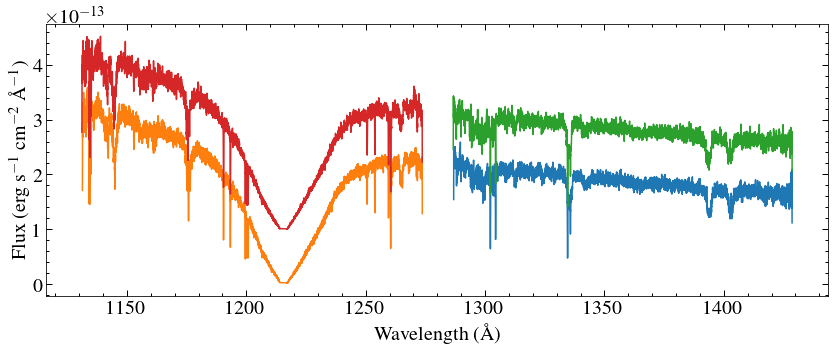

In [4]:
smooth = 5
for i, x in enumerate(x1ds):
    data = fits.getdata(x,1)
    for dt in data:
        w, f, e, dq = dt['WAVELENGTH'], dt['FLUX'], dt['ERROR'], dt['DQ']
        mask = (f>0) & (dq == 0) & (w < 1214) | (w > 1217) & (f>0) & (dq == 0) 
        w, f, e = w[mask], f[mask], e[mask]
        f = convolve(f,Box1DKernel(smooth))
        e = convolve(e,Box1DKernel(smooth))/(smooth**0.5)
        plt.plot(w, f+0.5*np.mean(f)*i)
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')

Just show one spectrum and a bunch of lines?

In [8]:
ism = Table.read('../../ism_lines.csv')
ism.dtype.names

('line', 'rest_lambda')

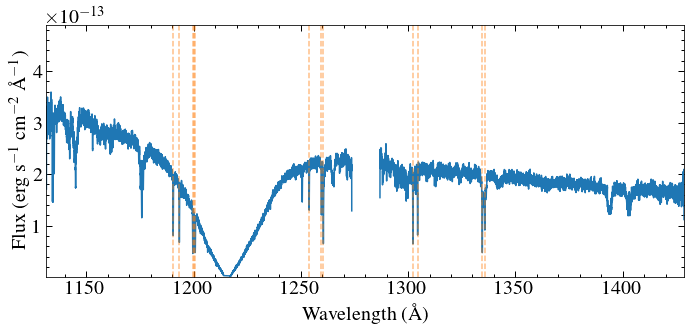

In [16]:
plt.figure(figsize=(10, 5))
smooth = 5
x = x1ds[0]
data = fits.getdata(x,1)
w0, w1 = 10000, 0
for dt in data:
    w, f, e, dq = dt['WAVELENGTH'], dt['FLUX'], dt['ERROR'], dt['DQ']
    mask = (f>0) & (dq == 0) & (w < 1214) | (w > 1217) & (f>0) & (dq == 0) 
    w, f, e = w[mask], f[mask], e[mask]
    if w[0] < w0:
        w0= w[0]
    if w[-1] > w1:
        w1 = w[-1]
    f = convolve(f,Box1DKernel(smooth))
    e = convolve(e,Box1DKernel(smooth))/(smooth**0.5)
    plt.plot(w, f, c='C0')
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
[plt.axvline(line, ls='--', c='C1', alpha=0.5) for line in ism['rest_lambda']]
plt.xlim(w0, w1)
plt.ylim(0.1e-14, 4.9e-13)
plt.tight_layout()
plt.savefig('plots/cc_cet_cos.pdf')

Looking for variation in the split spectra (try S iv lines)

(0.0, 3e-13)

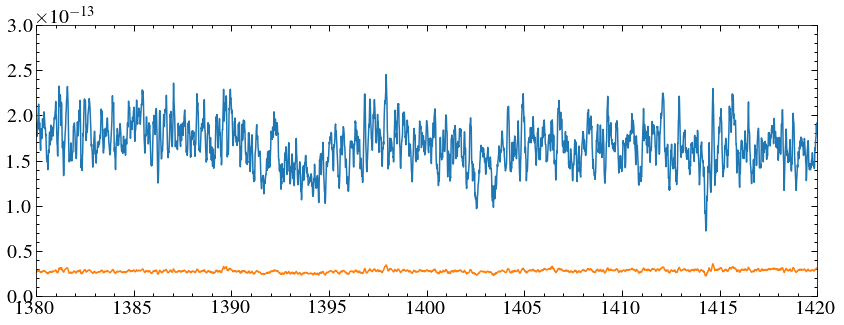

In [60]:
smooth=10
npath = '/media/david/5tb_storage1/cc_cet/hst/newx1ds/'
nx1ds = glob.glob(npath+'*100*x1d.fits')
data = fits.getdata(nx1ds[9], 1)[0]
w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
f = convolve(f,Box1DKernel(smooth))
e = convolve(e,Box1DKernel(smooth))/(smooth**0.5)
plt.plot(w, f)
plt.plot(w,e)
plt.xlim(1380, 1420)
plt.ylim(0, 3e-13)

In [64]:
times  = []
for x in nx1ds:
    hdr = fits.getheader(x,1)
    ti = (hdr['EXPSTART'] + hdr['EXPEND'])/2
    times.append(ti)
    
args = np.argsort(np.array(times))
nx1ds = np.array(nx1ds)[args]
times = np.array(times)[args]
    

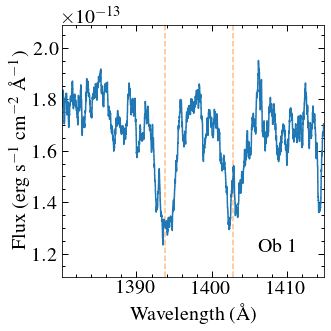

In [99]:
from matplotlib.animation import FuncAnimation
smooth=50

fig, ax = plt.subplots(figsize=(5,5))
fig.set_tight_layout(True)

#ax[0].plot(t, f_lc)
#ax[0].set_xlabel('Time (s)')
#ax[0].set_ylabel('Flux (erg s$^{-1}$ cm$^{-2}$)')
#ax[0].set_ylim(0.4, 1.2)
ax.set_xlim(1380.1, 1414.9)
ax.set_ylim(1.11e-13, 2.09e-13)

#line, = ax[0].plot([0,0], [-0.1e-12,1.3e-12], 'C1--', linewidth=2)
ax.set_ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
ax.set_xlabel('Wavelength (\AA)')
ax.axvline(1393.775, ls='--', c='C1', alpha=0.5)
ax.axvline(1402.770, ls='--', c='C1', alpha=0.5)
#[ax[1].axvline(line, ls='--', c='r') for line in [8498.02,8542.09,8662.14]]

#ext = hdul[1::][0]
#dt = ext.data[0]
#w, f = dt['WAVELENGTH'], dt['FLUX']
w, f, e = np.array([], dtype=float), np.array([], dtype=float), np.array([], dtype=float)
#w, f, e  = np.loadtxt(csv_files[0], unpack=True, delimiter=',')
line1, = ax.step(w,f, where='mid')
t0 = fits.getheader(nx1ds[0],1)['EXPSTART']
an = ax.annotate('', (0.75, 0.1), xycoords ='axes fraction')
obs = 1
def update(i):
    #time = t[i]
    #line.set_xdata([t[i], t[i]])
    #ext = hdul[1::][i]
    hdr = fits.getheader(nx1ds[i],1)
    ti = (hdr['EXPSTART'] + hdr['EXPEND'])/2
    if ti > 58152:
        obs=2
    else:
        obs = 1
    data = fits.getdata(nx1ds[i],1)[0]
    w, f = data['WAVELENGTH'], data['FLUX']
    f = convolve(f,Box1DKernel(smooth))
    line1.set_xdata(w)
    line1.set_ydata(f)
    
   ## if ti > t0+2:
     #   t0 = ti
      #  obs =
    an.set_text('Ob {0}'.format(obs))
 #   print(ti)
    return ax, line1, an
#ax.legend()
anim = FuncAnimation(fig, update, frames=np.arange(len(nx1ds)), interval=300)
anim.save('hst.gif', dpi=80, writer='imagemagick')
plt.show()



In [101]:
#gaia
p = 8.23807235942898e-3
pe = 0.07578241768233003e-3

d = 1/p
de = pe/p**2
print(d, de)
print(pe/p)

121.38762035216145 1.116650466958175
0.009199047346991606
